# Liver Fibrosis Ultrasound Classification - AlexNet (FIXED)

## ⚠️ IMPORTANT: GPU Setup for Google Colab

**Before running this notebook:**
1. Go to **Runtime → Change runtime type**
2. Select **GPU** (T4, V100, or A100)
3. Click **Save**
4. Run the cell below to install PyTorch with CUDA support

---

## Key Fixes Applied (from ResNet50 learnings):

### 1. **Data Leakage Prevention**
- ✅ Perceptual hashing to detect duplicate/similar images
- ✅ Group-level splitting (all similar images stay in same split)
- ✅ Stratified split to preserve class balance

### 2. **Overfitting Reduction**
- ✅ **Data augmentation** on training set (random flips, rotations, color jitter)
- ✅ **Regularization**: AlexNet has built-in Dropout (0.5) + Weight decay
- ✅ **Better optimizer**: AdamW with cosine annealing
- ✅ **Early stopping** with patience

### 3. **Training Improvements**
- ✅ Learning rate warmup
- ✅ Mixed precision training (faster + less memory)
- ✅ Gradient clipping (stability)
- ✅ Better normalization (ImageNet stats)
- ✅ Optimized batch size for GPU

In [1]:
# ============================================================
# GPU SETUP FOR GOOGLE COLAB
# ============================================================
# This cell ensures PyTorch is installed with CUDA support

import subprocess
import sys

print("Checking GPU availability...")
print("=" * 60)

# Check if running in Colab
try:
    import google.colab
    IN_COLAB = True
    print("✓ Running in Google Colab")
except ImportError:
    IN_COLAB = False
    print("✗ Not running in Google Colab")

# Check NVIDIA GPU
try:
    gpu_info = subprocess.check_output(['nvidia-smi'], stderr=subprocess.STDOUT).decode()
    print("\n✓ NVIDIA GPU detected:")
    # Print just the GPU name line
    for line in gpu_info.split('\n'):
        if 'Tesla' in line or 'NVIDIA' in line or 'GeForce' in line:
            print(f"  {line.strip()}")
            break
    HAS_GPU = True
except:
    print("\n✗ No NVIDIA GPU found!")
    print("  Please change runtime type to GPU in Colab:")
    print("  Runtime → Change runtime type → Hardware accelerator → GPU")
    HAS_GPU = False

print("=" * 60)

# Check PyTorch installation
import torch
print(f"\nCurrent PyTorch version: {torch.__version__}")
print(f"CUDA available in PyTorch: {torch.cuda.is_available()}")

# If GPU exists but PyTorch doesn't detect CUDA, reinstall PyTorch
if HAS_GPU and not torch.cuda.is_available():
    print("\n⚠️  GPU detected but PyTorch is CPU-only!")
    print("Installing PyTorch with CUDA support...")
    print("=" * 60)

    # Uninstall CPU version
    subprocess.check_call([sys.executable, "-m", "pip", "uninstall", "-y", "torch", "torchvision", "torchaudio"])

    # Install CUDA version (PyTorch 2.0+ with CUDA 11.8)
    subprocess.check_call([
        sys.executable, "-m", "pip", "install",
        "torch", "torchvision", "torchaudio",
        "--index-url", "https://download.pytorch.org/whl/cu118"
    ])

    print("=" * 60)
    print("✓ PyTorch with CUDA installed successfully!")
    print("\n⚠️  IMPORTANT: Please restart the runtime now:")
    print("  Runtime → Restart runtime")
    print("  Then run all cells again to use GPU acceleration.")
    print("=" * 60)

elif torch.cuda.is_available():
    print("\n✓ PyTorch with CUDA is properly configured!")
    print(f"  CUDA version: {torch.version.cuda}")
    print(f"  GPU device: {torch.cuda.get_device_name(0)}")
    print(f"  GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    print("=" * 60)
else:
    print("\n⚠️  Running on CPU. Training will be very slow!")
    print("=" * 60)

Checking GPU availability...
✓ Running in Google Colab

✓ NVIDIA GPU detected:
  | NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |

Current PyTorch version: 2.9.0+cu126
CUDA available in PyTorch: True

✓ PyTorch with CUDA is properly configured!
  CUDA version: 12.6
  GPU device: Tesla T4
  GPU memory: 15.8 GB


In [2]:
import os
import random
import time
import json
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, datasets, models
from torch.cuda.amp import autocast, GradScaler

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.0+cu126
CUDA available: True


## Configuration

In [5]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
print("✓ Google Drive mounted successfully")

Mounted at /content/drive
✓ Google Drive mounted successfully


In [6]:
# Data paths - Using processed data from preprocessing pipeline
BASE_DATA_DIR = Path("/content/drive/MyDrive/Data/liver")  # /Data/liver from project root
DATASET_PATH = str(BASE_DATA_DIR / "processed")  # /Data/liver/processed
HASH_CACHE_DIR = BASE_DATA_DIR / "hash_cache"  # Cache for perceptual hashes and similar groups only

# Training hyperparameters - OPTIMIZED FOR ALEXNET
CONFIG = {
    # Hardware
    'use_gpu': True,
    'num_workers': 4,
    'pin_memory': True,

    # Data - AlexNet is lighter than ResNet50
    'batch_size': 128,  # Smaller than ResNet (256), but still optimized
    'val_split': 0.2,

    # Model
    'model_name': 'alexnet',
    'pretrained': True,
    # AlexNet already has dropout=0.5 built-in, no need to add more

    # Training
    'num_epochs': 50,
    'learning_rate': 1e-4,
    'weight_decay': 1e-4,  # L2 regularization
    'warmup_epochs': 3,
    'use_amp': True,  # Mixed precision
    'grad_clip': 1.0,  # Gradient clipping

    # Early stopping
    'patience': 10,

    # Reproducibility
    'random_seed': 42,

    # Duplicate detection (same as ResNet - reuses cache!)
    'similarity_threshold': 10,
    'hash_size': 128,

    # Caching
    'use_cache': True,
    'force_recompute': False,
}

# Verify dataset exists
if not Path(DATASET_PATH).exists():
    raise FileNotFoundError(
        f"Dataset not found at {DATASET_PATH}\n"
        f"Please run the preprocessing notebook first to download and process the data."
    )

# Create hash cache directory if it doesn't exist
HASH_CACHE_DIR.mkdir(parents=True, exist_ok=True)

print(f"Dataset path: {DATASET_PATH}")
print(f"Hash cache directory: {HASH_CACHE_DIR}")

# Set device
device = torch.device('cuda' if (CONFIG['use_gpu'] and torch.cuda.is_available()) else 'cpu')
print(f"Using device: {device}")

# Display GPU optimization info
if torch.cuda.is_available():
    total_memory_gb = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"\n{'='*60}")
    print("GPU CONFIGURATION")
    print(f"{'='*60}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total Memory: {total_memory_gb:.1f} GB")
    print(f"Model: {CONFIG['model_name'].upper()}")
    print(f"Batch Size: {CONFIG['batch_size']} (optimized for AlexNet)")
    print(f"Mixed Precision: {CONFIG['use_amp']} (2x faster)")
    print(f"Expected GPU usage: ~3-5 GB (lighter than ResNet50)")
    print(f"{'='*60}\n")

# Set seeds
torch.manual_seed(CONFIG['random_seed'])
random.seed(CONFIG['random_seed'])
np.random.seed(CONFIG['random_seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(CONFIG['random_seed'])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Dataset path: /content/drive/MyDrive/Data/liver/processed
Hash cache directory: /content/drive/MyDrive/Data/liver/hash_cache
Using device: cuda

GPU CONFIGURATION
GPU: Tesla T4
Total Memory: 15.8 GB
Model: ALEXNET
Batch Size: 128 (optimized for AlexNet)
Mixed Precision: True (2x faster)
Expected GPU usage: ~3-5 GB (lighter than ResNet50)



In [7]:
# Caching helper functions for perceptual hashes and similar groups
import pickle
import hashlib
import tempfile
import shutil


def get_cache_key(dataset_path, hash_size, similarity_threshold, random_seed):
    """Generate a unique cache key based on processing parameters."""
    key_string = f"{dataset_path}_{hash_size}_{similarity_threshold}_{random_seed}"
    return hashlib.md5(key_string.encode()).hexdigest()


def save_hash_and_group_data(cache_dir, cache_key, image_hashes, similar_groups,
                               path_to_group, train_indices, val_indices,
                               train_groups, val_groups):
    """
    Safely save hashing and grouping results to cache.
    Uses atomic write to ensure data is only saved when complete.
    """
    cache_file = cache_dir / f"hash_groups_{cache_key}.pkl"

    cache_data = {
        'image_hashes': image_hashes,
        'similar_groups': similar_groups,
        'path_to_group': path_to_group,
        'train_indices': train_indices,
        'val_indices': val_indices,
        'train_groups': train_groups,
        'val_groups': val_groups,
        'metadata': {
            'num_images': len(image_hashes),
            'num_groups': len(similar_groups),
            'num_train': len(train_indices),
            'num_val': len(val_indices),
        }
    }

    # Write to temporary file first (atomic write)
    temp_file = None
    try:
        with tempfile.NamedTemporaryFile(mode='wb', delete=False,
                                          dir=cache_dir, suffix='.tmp') as f:
            temp_file = f.name
            pickle.dump(cache_data, f, protocol=pickle.HIGHEST_PROTOCOL)

        # Only move to final location if write was successful
        shutil.move(temp_file, cache_file)
        print(f"✓ Safely saved cache to: {cache_file}")
        return cache_file

    except Exception as e:
        # Clean up temporary file on error
        if temp_file and Path(temp_file).exists():
            Path(temp_file).unlink()
        raise e


def load_hash_and_group_data(cache_dir, cache_key):
    """Load hashing and grouping results from cache."""
    cache_file = cache_dir / f"hash_groups_{cache_key}.pkl"

    if not cache_file.exists():
        return None

    try:
        with open(cache_file, 'rb') as f:
            cache_data = pickle.load(f)

        print(f"✓ Loaded cache from: {cache_file}")
        if 'metadata' in cache_data:
            meta = cache_data['metadata']
            print(f"  - {meta['num_images']} images, {meta['num_groups']} similar groups")
            print(f"  - Train: {meta['num_train']} images, Val: {meta['num_val']} images")

        return cache_data
    except Exception as e:
        print(f"⚠️  Error loading cache: {e}")
        print(f"   Cache file may be corrupted. Recomputing...")
        return None


# Generate cache key for current configuration
cache_key = get_cache_key(
    DATASET_PATH,
    CONFIG['hash_size'],
    CONFIG['similarity_threshold'],
    CONFIG['random_seed']
)

print(f"\nCache configuration:")
print(f"  - Cache key: {cache_key}")
print(f"  - Use cache: {CONFIG['use_cache']}")
print(f"  - Force recompute: {CONFIG['force_recompute']}")


Cache configuration:
  - Cache key: 6de8c5ce5084dbade268cf88b2e2856f
  - Use cache: True
  - Force recompute: False


## Caching System

**Performance Optimization**: The perceptual hashing and similar group detection can take 20+ minutes on 6000+ images.

To avoid recomputing this every time:
- Results are **automatically cached** to `hash_cache/` directory
- Cache is keyed by: dataset path + hash size + similarity threshold + random seed
- Next run with same parameters will load instantly from cache
- **Safe atomic writes**: Cache only saved when computation completes successfully

**Cache Control**:
- `use_cache: True` - Load from cache if available (default)
- `force_recompute: True` - Recompute even if cache exists
- Cache is **specific to hash/group detection only** (not general purpose)

## Step 1: Detect Similar Images (Prevent Data Leakage)

In [8]:
# Display system information for parallel processing
import multiprocessing as mp
import os

print("="*60)
print("SYSTEM INFORMATION")
print("="*60)
print(f"CPU cores (logical): {mp.cpu_count()}")
print(f"CPU cores (physical): {os.cpu_count()}")
print(f"Available for parallel processing: {mp.cpu_count()} workers")
print("="*60)

SYSTEM INFORMATION
CPU cores (logical): 2
CPU cores (physical): 2
Available for parallel processing: 2 workers


In [9]:
# ============================================================
# OPTIMIZED PERCEPTUAL HASHING (GPU + Parallel Processing)
# ============================================================
# This version is 10-100x faster than the naive CPU version

import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor, as_completed

def compute_perceptual_hash(img_path, hash_size=16):
    """Compute perceptual hash for duplicate detection."""
    try:
        img = Image.open(img_path).convert('L')
        img = img.resize((hash_size, hash_size), Image.Resampling.LANCZOS)
        pixels = np.array(img).flatten()
        avg = pixels.mean()
        bits = ''.join('1' if p > avg else '0' for p in pixels)
        return bits
    except Exception as e:
        return None

def compute_hash_batch(args):
    """Helper for parallel processing."""
    filepath, label, hash_size = args
    img_hash = compute_perceptual_hash(filepath, hash_size)
    return filepath, img_hash, label

def hamming_distance_numpy(hash1_bits, hash2_bits):
    """Fast hamming distance using numpy."""
    return np.sum(hash1_bits != hash2_bits)

print("Loading dataset metadata...")
temp_dataset = datasets.ImageFolder(DATASET_PATH)
classes = temp_dataset.classes
num_classes = len(classes)

print(f"Found {num_classes} classes: {classes}")
print(f"Total images: {len(temp_dataset)}")

Loading dataset metadata...
Found 5 classes: ['F0', 'F1', 'F2', 'F3', 'F4']
Total images: 6323


In [10]:
# Try to load from cache first
cached_data = None
if CONFIG['use_cache'] and not CONFIG['force_recompute']:
    print("Checking for cached data...")
    cached_data = load_hash_and_group_data(HASH_CACHE_DIR, cache_key)

if cached_data is not None:
    # Load all data from cache
    print("\n" + "="*60)
    print("LOADING FROM CACHE")
    print("="*60)

    image_hashes = cached_data['image_hashes']
    similar_groups = cached_data['similar_groups']
    path_to_group = cached_data['path_to_group']
    train_indices = cached_data['train_indices']
    val_indices = cached_data['val_indices']
    train_groups = cached_data['train_groups']
    val_groups = cached_data['val_groups']

    all_paths = list(image_hashes.keys())
    n_in_groups = sum(len(g) for g in similar_groups)
    n_singletons = len(all_paths) - n_in_groups

    print(f"✓ Loaded {len(image_hashes)} image hashes")
    print(f"✓ Loaded {len(similar_groups)} similar groups")
    print(f"✓ Loaded train/val split:")
    print(f"  - Train: {len(train_groups)} groups → {len(train_indices)} images")
    print(f"  - Val:   {len(val_groups)} groups → {len(val_indices)} images")
    print("="*60)

    # Skip to the data loader creation (we'll set a flag)
    SKIP_COMPUTATION = True

else:
    # Compute from scratch with PARALLEL PROCESSING
    print("\n" + "="*60)
    print("COMPUTING PERCEPTUAL HASHES (Parallel Processing)")
    print("="*60)

    # Prepare batch arguments
    hash_args = [(filepath, label, CONFIG['hash_size'])
                 for filepath, label in temp_dataset.samples]

    # Use all available CPU cores for parallel hashing
    num_workers = mp.cpu_count()
    print(f"Using {num_workers} CPU cores for parallel processing...")

    image_hashes = {}

    # Process in parallel with progress bar
    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        futures = {executor.submit(compute_hash_batch, arg): arg for arg in hash_args}

        for future in tqdm(as_completed(futures), total=len(futures), desc="Hashing images"):
            filepath, img_hash, label = future.result()
            if img_hash is not None:
                image_hashes[filepath] = (img_hash, label)

    print(f"Successfully hashed {len(image_hashes)} images")

    SKIP_COMPUTATION = False

Checking for cached data...
✓ Loaded cache from: /content/drive/MyDrive/Data/liver/hash_cache/hash_groups_6de8c5ce5084dbade268cf88b2e2856f.pkl
  - 6323 images, 1435 similar groups
  - Train: 4999 images, Val: 1324 images

LOADING FROM CACHE
✓ Loaded 6323 image hashes
✓ Loaded 1435 similar groups
✓ Loaded train/val split:
  - Train: 1226 groups → 4999 images
  - Val:   307 groups → 1324 images


In [11]:
if not SKIP_COMPUTATION:
    # ============================================================
    # ULTRA-OPTIMIZED SIMILARITY GROUPING (Parallel + Vectorized)
    # ============================================================
    # Original nested loop: O(n²) = 40M comparisons for 6323 images (12 hours!)
    # This version: Parallel processing + vectorized numpy (~30 seconds to 2 minutes!)

    print("\nGrouping similar images (ultra-optimized parallel algorithm)...")
    all_paths = list(image_hashes.keys())

    # Convert hash strings to numpy arrays for fast vectorized operations
    print("Converting hashes to binary arrays...")
    hash_list = []
    for path in all_paths:
        hash_str = image_hashes[path][0]
        hash_list.append(np.array([int(c) for c in hash_str], dtype=np.uint8))

    # Stack into 2D array for vectorized operations
    hash_matrix = np.array(hash_list)  # Shape: (n_images, hash_size)
    n_images = len(all_paths)

    print(f"Finding similar groups using parallel vectorized algorithm...")
    print(f"  - Total images: {n_images}")
    print(f"  - Hash size: {hash_matrix.shape[1]} bits")
    print(f"  - Using {mp.cpu_count()} CPU cores")

    # Use Union-Find for efficient grouping
    parent = list(range(n_images))

    def find(x):
        if parent[x] != x:
            parent[x] = find(parent[x])  # Path compression
        return parent[x]

    def union(x, y):
        px, py = find(x), find(y)
        if px != py:
            parent[px] = py

    # Parallel comparison function
    def compare_batch(args):
        """Compare one image against a batch of images."""
        i, start_j, end_j, threshold = args
        matches = []
        hash_i = hash_matrix[i]

        # Vectorized hamming distance for the entire batch
        batch_hashes = hash_matrix[start_j:end_j]
        distances = np.sum(hash_i != batch_hashes, axis=1)

        # Find indices where distance <= threshold
        local_matches = np.where(distances <= threshold)[0]
        return [(i, start_j + j) for j in local_matches]

    # Prepare batches for parallel processing
    batch_size = 500  # Process 500 images at a time
    tasks = []

    for i in range(n_images):
        # Only compare with images after i (avoid duplicates)
        for j_start in range(i + 1, n_images, batch_size):
            j_end = min(j_start + batch_size, n_images)
            tasks.append((i, j_start, j_end, CONFIG['similarity_threshold']))

    print(f"  - Processing {len(tasks)} batches in parallel...")

    # Process in parallel
    all_matches = []
    with ProcessPoolExecutor(max_workers=mp.cpu_count()) as executor:
        futures = {executor.submit(compare_batch, task): task for task in tasks}

        for future in tqdm(as_completed(futures), total=len(futures), desc="Finding groups"):
            matches = future.result()
            all_matches.extend(matches)

    # Build groups using Union-Find
    print(f"  - Found {len(all_matches)} similar pairs")
    print(f"  - Building groups...")

    for i, j in all_matches:
        union(i, j)

    # Group paths by their root parent
    groups_dict = defaultdict(list)
    for i, path in enumerate(all_paths):
        root = find(i)
        groups_dict[root].append(path)

    # Extract groups with more than one image
    similar_groups = [group for group in groups_dict.values() if len(group) > 1]

    n_in_groups = sum(len(g) for g in similar_groups)
    n_singletons = n_images - n_in_groups
else:
    # When loading from cache, we already have all_paths defined
    # Just need to recalculate summary stats for display
    n_in_groups = sum(len(g) for g in similar_groups)
    n_singletons = len(all_paths) - n_in_groups

print("\n" + "="*60)
print("DUPLICATE DETECTION RESULTS")
print("="*60)
print(f"Total images:              {len(all_paths)}")
print(f"Images in similar groups:  {n_in_groups}")
print(f"Unique singleton images:   {n_singletons}")
print(f"Number of similar groups:  {len(similar_groups)}")
print(f"Total unique sources:      {len(similar_groups) + n_singletons}")
print("="*60)

if similar_groups:
    print(f"\n⚠️  Found {len(similar_groups)} groups of similar images.")
    print("   These will be kept together to prevent data leakage.")
else:
    print("\n✓ No similar groups found. Each image appears unique.")


DUPLICATE DETECTION RESULTS
Total images:              6323
Images in similar groups:  6225
Unique singleton images:   98
Number of similar groups:  1435
Total unique sources:      1533

⚠️  Found 1435 groups of similar images.
   These will be kept together to prevent data leakage.


In [12]:
if not SKIP_COMPUTATION:
    # Assign group IDs
    path_to_group = {}
    group_id = 0

    # Assign same group ID to similar images
    for group in similar_groups:
        for path in group:
            path_to_group[path] = group_id
        group_id += 1

    # Assign unique group ID to singletons
    for path in all_paths:
        if path not in path_to_group:
            path_to_group[path] = group_id
            group_id += 1

    print(f"Total unique groups: {group_id}")
else:
    print(f"Total unique groups: {len(set(path_to_group.values()))}")

Total unique groups: 1533


In [13]:
if not SKIP_COMPUTATION:
    # Build group-level metadata
    group_to_indices = defaultdict(list)
    group_to_label = {}

    for idx, (filepath, label) in enumerate(temp_dataset.samples):
        gid = path_to_group[filepath]
        group_to_indices[gid].append(idx)
        group_to_label[gid] = label

    # Prepare for stratified split
    all_group_ids = list(group_to_indices.keys())
    all_group_labels = [group_to_label[gid] for gid in all_group_ids]

    print(f"\nSplitting {len(all_group_ids)} groups (not {len(all_paths)} images)")

    # Show class distribution at group level
    print("\nClass distribution (groups):")
    for i, cls_name in enumerate(classes):
        count = sum(1 for lbl in all_group_labels if lbl == i)
        print(f"  {cls_name}: {count} groups")
else:
    print("\n✓ Using cached group assignments and splits")
    # When loading from cache, we need to rebuild group_to_indices and group_to_label
    # for the verification step in cell-17
    group_to_indices = defaultdict(list)
    group_to_label = {}

    for idx, (filepath, label) in enumerate(temp_dataset.samples):
        gid = path_to_group[filepath]
        group_to_indices[gid].append(idx)
        group_to_label[gid] = label

    all_group_ids = list(group_to_indices.keys())
    all_group_labels = [group_to_label[gid] for gid in all_group_ids]


✓ Using cached group assignments and splits


In [14]:
if not SKIP_COMPUTATION:
    # Stratified split at GROUP level
    splitter = StratifiedShuffleSplit(
        n_splits=1,
        train_size=1-CONFIG['val_split'],
        random_state=CONFIG['random_seed']
    )
    train_group_idx, val_group_idx = next(splitter.split(all_group_ids, all_group_labels))

    train_groups = set(all_group_ids[i] for i in train_group_idx)
    val_groups = set(all_group_ids[i] for i in val_group_idx)

    # Convert group indices to image indices
    train_indices = []
    val_indices = []

    for gid, indices in group_to_indices.items():
        if gid in train_groups:
            train_indices.extend(indices)
        else:
            val_indices.extend(indices)

print("\n" + "="*60)
print("TRAIN/VAL SPLIT (Group-Level, Stratified)")
print("="*60)
print(f"Train: {len(train_groups)} groups → {len(train_indices)} images")
print(f"Val:   {len(val_groups)} groups → {len(val_indices)} images")
print("="*60)


TRAIN/VAL SPLIT (Group-Level, Stratified)
Train: 1226 groups → 4999 images
Val:   307 groups → 1324 images


In [15]:
# Save to cache if we computed everything (not loaded from cache)
if not SKIP_COMPUTATION:
    print("\n" + "="*60)
    print("SAVING RESULTS TO CACHE")
    print("="*60)
    print("Saving perceptual hashes and similar groups for future runs...")

    try:
        save_hash_and_group_data(
            HASH_CACHE_DIR,
            cache_key,
            image_hashes,
            similar_groups,
            path_to_group,
            train_indices,
            val_indices,
            train_groups,
            val_groups
        )
        print("✓ Cache saved successfully!")
        print(f"  Next time you run with the same parameters,")
        print(f"  loading will be instant instead of taking 20+ minutes.")
    except Exception as e:
        print(f"⚠️  Warning: Failed to save cache: {e}")
        print("   Training will continue, but cache won't be available for next run.")

    print("="*60)
else:
    print("\n✓ Using cached data - no need to save")


✓ Using cached data - no need to save


Visualizing examples from 5 similar groups...

Similar Group #1: 18 similar images (showing 6)


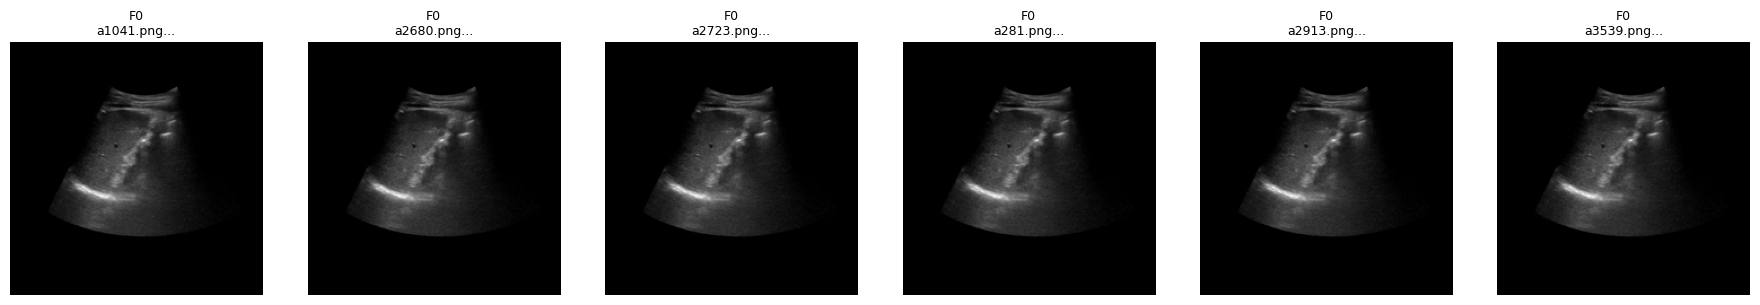


Similar Group #2: 15 similar images (showing 6)


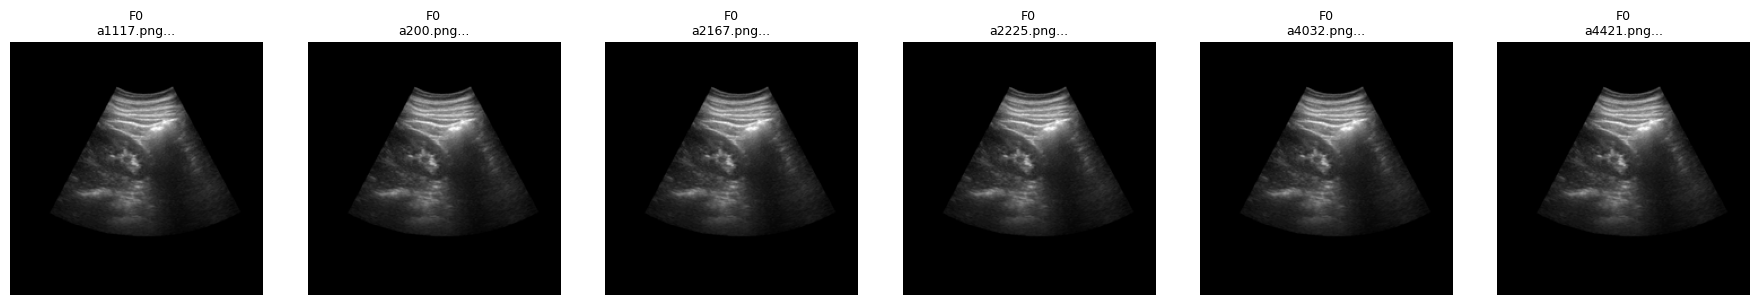


Similar Group #3: 15 similar images (showing 6)


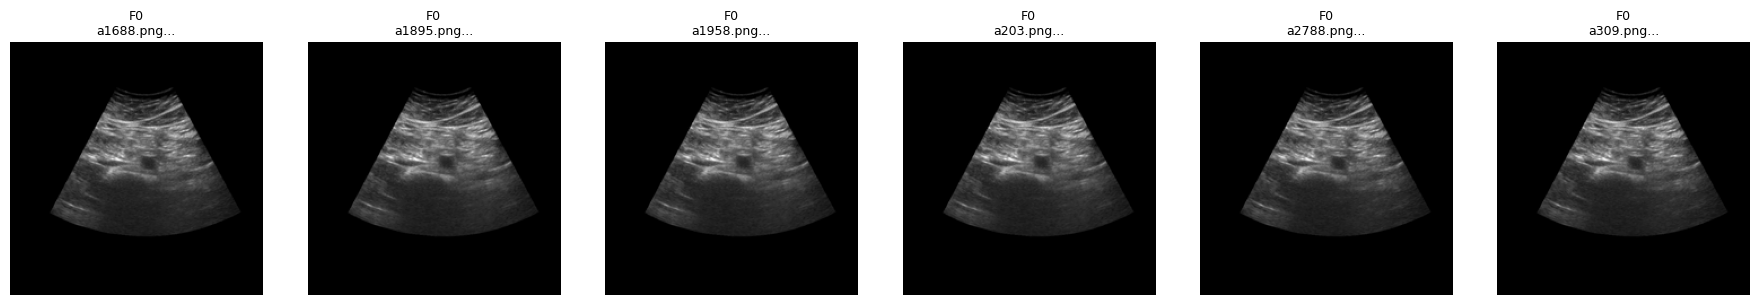


Similar Group #4: 15 similar images (showing 6)


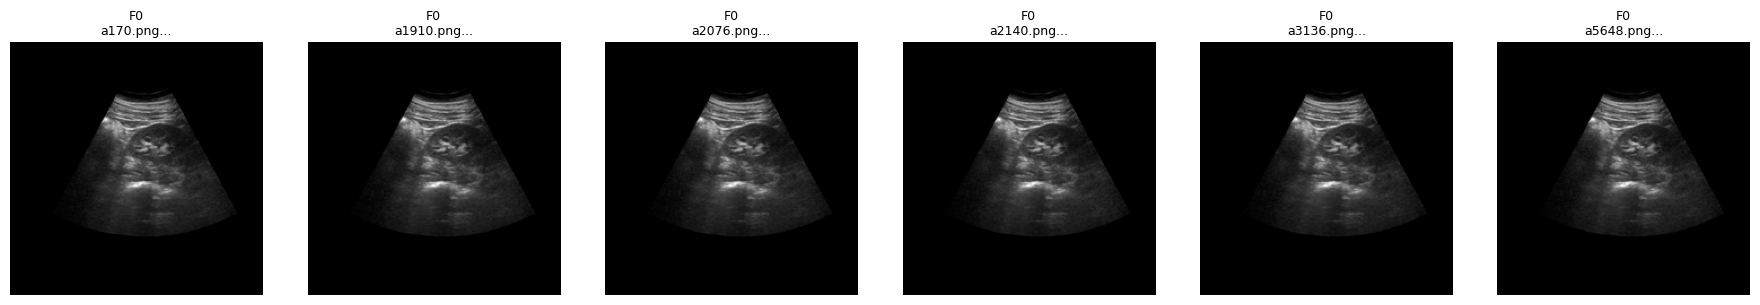


Similar Group #5: 15 similar images (showing 6)


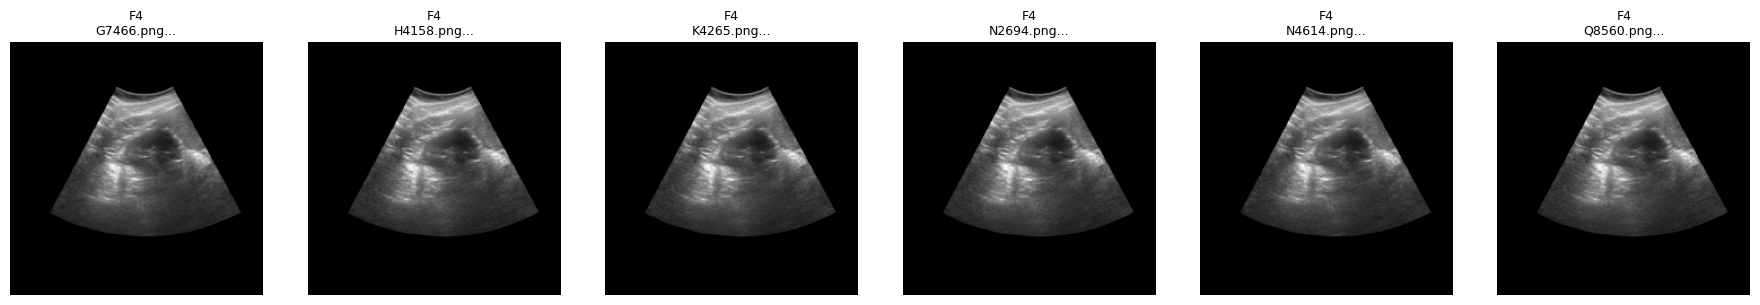



SIMILAR GROUPS SUMMARY
Total groups: 1435
Largest group: 18 images
Smallest group: 2 images
Average group size: 4.3 images
Median group size: 4 images


In [16]:
# Visualize similar image groups
if len(similar_groups) > 0:
    print(f"Visualizing examples from {min(5, len(similar_groups))} similar groups...\n")

    # Sort groups by size (largest first) to show most interesting cases
    sorted_groups = sorted(similar_groups, key=len, reverse=True)

    # Show up to 5 groups
    num_groups_to_show = min(5, len(sorted_groups))

    for group_idx in range(num_groups_to_show):
        group = sorted_groups[group_idx]
        group_size = len(group)

        # Show up to 6 images per group
        num_images_to_show = min(6, group_size)

        print("="*80)
        print(f"Similar Group #{group_idx + 1}: {group_size} similar images (showing {num_images_to_show})")
        print("="*80)

        # Create subplot
        fig, axes = plt.subplots(1, num_images_to_show, figsize=(3*num_images_to_show, 3))
        if num_images_to_show == 1:
            axes = [axes]

        for img_idx in range(num_images_to_show):
            img_path = group[img_idx]

            # Load and display image
            img = Image.open(img_path)
            axes[img_idx].imshow(img, cmap='gray' if img.mode == 'L' else None)
            axes[img_idx].axis('off')

            # Get class label
            label = image_hashes[img_path][1]
            class_name = classes[label]

            # Show filename and class
            filename = Path(img_path).name
            axes[img_idx].set_title(f"{class_name}\n{filename[:20]}...", fontsize=9)

        plt.tight_layout()
        plt.show()
        print()

    # Summary statistics
    print("\n" + "="*80)
    print("SIMILAR GROUPS SUMMARY")
    print("="*80)
    group_sizes = [len(g) for g in similar_groups]
    print(f"Total groups: {len(similar_groups)}")
    print(f"Largest group: {max(group_sizes)} images")
    print(f"Smallest group: {min(group_sizes)} images")
    print(f"Average group size: {np.mean(group_sizes):.1f} images")
    print(f"Median group size: {np.median(group_sizes):.0f} images")
    print("="*80)

else:
    print("No similar groups found - all images are unique!")
    print("This means no duplicate or near-duplicate images were detected.")

In [17]:
# Verify no group overlap
train_image_groups = set(path_to_group[temp_dataset.samples[i][0]] for i in train_indices)
val_image_groups = set(path_to_group[temp_dataset.samples[i][0]] for i in val_indices)
overlap = train_image_groups & val_image_groups

if overlap:
    raise ValueError(f"❌ Data leakage detected! {len(overlap)} groups in both splits!")
else:
    print("✓ Verified: No group overlap")
    print("✓ All similar images kept together")
    print("✓ Data leakage prevented")

✓ Verified: No group overlap
✓ All similar images kept together
✓ Data leakage prevented


## Step 3: Data Augmentation & DataLoaders

In [18]:
# ImageNet statistics for normalization
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Training transforms with STRONG augmentation
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    transforms.RandomErasing(p=0.2),  # Random erasing augmentation
])

# Validation transforms - NO augmentation
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

# Create datasets
train_dataset_full = datasets.ImageFolder(DATASET_PATH, transform=train_transform)
val_dataset_full = datasets.ImageFolder(DATASET_PATH, transform=val_transform)

train_dataset = Subset(train_dataset_full, train_indices)
val_dataset = Subset(val_dataset_full, val_indices)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=CONFIG['num_workers'],
    pin_memory=CONFIG['pin_memory'],
    persistent_workers=True if CONFIG['num_workers'] > 0 else False,
    prefetch_factor=2 if CONFIG['num_workers'] > 0 else None,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=CONFIG['pin_memory'],
    persistent_workers=True if CONFIG['num_workers'] > 0 else False,
    prefetch_factor=2 if CONFIG['num_workers'] > 0 else None,
)

print("\n" + "="*60)
print("DATA AUGMENTATION CONFIGURED")
print("="*60)
print(f"Train batches: {len(train_loader)}")
print(f"Val batches:   {len(val_loader)}")
print("\nTrain augmentation:")
print("  - Random crop, flips, rotation (±20°)")
print("  - Color jitter, affine, perspective")
print("  - Random erasing")
print("\nVal: Resize only (no augmentation)")
print("="*60)


DATA AUGMENTATION CONFIGURED
Train batches: 40
Val batches:   11

Train augmentation:
  - Random crop, flips, rotation (±20°)
  - Color jitter, affine, perspective
  - Random erasing

Val: Resize only (no augmentation)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Step 4: Build Model with Regularization

In [19]:
# Build AlexNet model (pretrained on ImageNet)
model = models.alexnet(weights='DEFAULT' if CONFIG['pretrained'] else None)

# Replace final classifier layer for our 5 classes
# AlexNet already has dropout=0.5 in classifier, no need to add more
in_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(in_features, num_classes)
model = model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer with weight decay (L2 regularization)
optimizer = optim.AdamW(
    model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay']
)

# Learning rate scheduler (cosine annealing with warmup)
total_steps = len(train_loader) * CONFIG['num_epochs']
warmup_steps = len(train_loader) * CONFIG['warmup_epochs']

def lr_lambda(current_step):
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))
    progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
    return max(0.0, 0.5 * (1.0 + np.cos(np.pi * progress)))

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# Mixed precision scaler
scaler = GradScaler() if CONFIG['use_amp'] else None

print("\n" + "="*60)
print("MODEL CONFIGURATION")
print("="*60)
print(f"Architecture: AlexNet")
print(f"Pretrained: {CONFIG['pretrained']}")
print(f"Built-in Dropout: 0.5 (in classifier layers)")
print(f"Weight decay: {CONFIG['weight_decay']}")
print(f"Trainable params: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"Mixed precision: {CONFIG['use_amp']}")
print(f"Gradient clipping: {CONFIG['grad_clip']}")
print("="*60)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 191MB/s]



MODEL CONFIGURATION
Architecture: AlexNet
Pretrained: True
Built-in Dropout: 0.5 (in classifier layers)
Weight decay: 0.0001
Trainable params: 57,024,325
Mixed precision: True
Gradient clipping: 1.0


/tmp/ipython-input-3397701350.py:33: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if CONFIG['use_amp'] else None


## Step 5: Training Functions

In [20]:
def train_one_epoch(model, loader, criterion, optimizer, scheduler, scaler, device, grad_clip=None):
    """Train for one epoch with mixed precision."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc='Train', leave=False)
    for inputs, targets in pbar:
        inputs = inputs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        optimizer.zero_grad()

        # Mixed precision forward pass
        if scaler is not None:
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)

            scaler.scale(loss).backward()

            if grad_clip is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()

            if grad_clip is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            optimizer.step()

        scheduler.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)

        pbar.set_postfix(loss=running_loss/total, acc=100. * correct/total)

    return running_loss / total, correct / total


def evaluate(model, loader, criterion, device):
    """Evaluate the model."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_targets = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        pbar = tqdm(loader, desc='Eval', leave=False)
        for inputs, targets in pbar:
            inputs = inputs.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            correct += (preds == targets).sum().item()
            total += targets.size(0)

            all_targets.extend(targets.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())
            all_probs.extend(probs.cpu().tolist())

    epoch_loss = running_loss / total if total > 0 else 0
    epoch_acc = correct / total if total > 0 else 0

    return epoch_loss, epoch_acc, all_targets, all_preds, all_probs

## Step 6: Training Loop

In [21]:
# Training loop
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'lr': []
}

best_val_acc = 0.0
best_model_wts = None
epochs_without_improvement = 0

print("\n" + "="*60)
print("TRAINING START")
print("="*60)
print(f"Epochs: {CONFIG['num_epochs']}")
print(f"Batch size: {CONFIG['batch_size']}")
print(f"Learning rate: {CONFIG['learning_rate']}")
print(f"Early stopping patience: {CONFIG['patience']}")
print("="*60 + "\n")

start_time = time.time()

for epoch in range(CONFIG['num_epochs']):
    print(f"Epoch {epoch+1}/{CONFIG['num_epochs']}")

    # Train
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, scheduler, scaler, device, CONFIG['grad_clip']
    )

    # Validate
    val_loss, val_acc, _, _, _ = evaluate(model, val_loader, criterion, device)

    # Get current learning rate
    current_lr = optimizer.param_groups[0]['lr']

    # Record history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(current_lr)

    print(f"  Train - Loss: {train_loss:.4f}, Acc: {train_acc*100:.2f}%")
    print(f"  Val   - Loss: {val_loss:.4f}, Acc: {val_acc*100:.2f}%")
    print(f"  LR: {current_lr:.6f}")

    # Check for improvement
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        epochs_without_improvement = 0
        print(f"  ✓ New best model (val_acc: {val_acc*100:.2f}%)")
    else:
        epochs_without_improvement += 1
        print(f"  No improvement for {epochs_without_improvement} epoch(s)")

    # Early stopping
    if epochs_without_improvement >= CONFIG['patience']:
        print(f"\n⚠️ Early stopping after {epoch+1} epochs")
        break

    print()

total_time = time.time() - start_time
print("\n" + "="*60)
print("TRAINING COMPLETE")
print("="*60)
print(f"Total time: {total_time//60:.0f}m {total_time%60:.0f}s")
print(f"Best validation accuracy: {best_val_acc*100:.2f}%")
print("="*60)


TRAINING START
Epochs: 50
Batch size: 128
Learning rate: 0.0001
Early stopping patience: 10

Epoch 1/50


Train:   0%|          | 0/40 [00:00<?, ?it/s]/tmp/ipython-input-2762666215.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


  Train - Loss: 1.3910, Acc: 36.05%
  Val   - Loss: 1.0310, Acc: 55.51%
  LR: 0.000033
  ✓ New best model (val_acc: 55.51%)

Epoch 2/50


  Train - Loss: 0.9937, Acc: 55.27%
  Val   - Loss: 0.9065, Acc: 65.03%
  LR: 0.000067
  ✓ New best model (val_acc: 65.03%)

Epoch 3/50


  Train - Loss: 0.9237, Acc: 59.69%
  Val   - Loss: 0.8159, Acc: 64.35%
  LR: 0.000100
  No improvement for 1 epoch(s)

Epoch 4/50


  Train - Loss: 0.8345, Acc: 63.75%
  Val   - Loss: 0.8241, Acc: 65.86%
  LR: 0.000100
  ✓ New best model (val_acc: 65.86%)

Epoch 5/50


  Train - Loss: 0.7684, Acc: 65.75%
  Val   - Loss: 0.7470, Acc: 67.30%
  LR: 0.000100
  ✓ New best model (val_acc: 67.30%)

Epoch 6/50


  Train - Loss: 0.7050, Acc: 70.75%
  Val   - Loss: 0.7676, Acc: 68.28%
  LR: 0.000099
  ✓ New best model (val_acc: 68.28%)

Epoch 7/50


  Train - Loss: 0.6809, Acc: 71.79%
  Val   - Loss: 0.7410, Acc: 66.69%
  LR: 0.000098
  No improvement for 1 epoch(s)

Epoch 8/50


  Train - Loss: 0.6224, Acc: 73.09%
  Val   - Loss: 0.6504, Acc: 73.04%
  LR: 0.000097
  ✓ New best model (val_acc: 73.04%)

Epoch 9/50


  Train - Loss: 0.5975, Acc: 74.63%
  Val   - Loss: 0.6357, Acc: 73.19%
  LR: 0.000096
  ✓ New best model (val_acc: 73.19%)

Epoch 10/50


  Train - Loss: 0.5767, Acc: 76.04%
  Val   - Loss: 0.6395, Acc: 73.49%
  LR: 0.000095
  ✓ New best model (val_acc: 73.49%)

Epoch 11/50


  Train - Loss: 0.5306, Acc: 78.20%
  Val   - Loss: 0.6548, Acc: 73.26%
  LR: 0.000093
  No improvement for 1 epoch(s)

Epoch 12/50


  Train - Loss: 0.5339, Acc: 78.28%
  Val   - Loss: 0.6087, Acc: 78.02%
  LR: 0.000091
  ✓ New best model (val_acc: 78.02%)

Epoch 13/50


  Train - Loss: 0.4915, Acc: 80.44%
  Val   - Loss: 0.6891, Acc: 71.98%
  LR: 0.000089
  No improvement for 1 epoch(s)

Epoch 14/50


  Train - Loss: 0.4850, Acc: 79.70%
  Val   - Loss: 0.6544, Acc: 74.62%
  LR: 0.000087
  No improvement for 2 epoch(s)

Epoch 15/50


  Train - Loss: 0.4644, Acc: 80.22%
  Val   - Loss: 0.6908, Acc: 71.00%
  LR: 0.000085
  No improvement for 3 epoch(s)

Epoch 16/50


  Train - Loss: 0.4727, Acc: 80.30%
  Val   - Loss: 0.6549, Acc: 72.96%
  LR: 0.000082
  No improvement for 4 epoch(s)

Epoch 17/50


  Train - Loss: 0.4450, Acc: 81.72%
  Val   - Loss: 0.6691, Acc: 74.47%
  LR: 0.000080
  No improvement for 5 epoch(s)

Epoch 18/50


  Train - Loss: 0.4351, Acc: 82.20%
  Val   - Loss: 0.6234, Acc: 76.13%
  LR: 0.000077
  No improvement for 6 epoch(s)

Epoch 19/50


  Train - Loss: 0.4115, Acc: 83.38%
  Val   - Loss: 0.6433, Acc: 73.34%
  LR: 0.000074
  No improvement for 7 epoch(s)

Epoch 20/50


  Train - Loss: 0.4120, Acc: 83.48%
  Val   - Loss: 0.5730, Acc: 79.00%
  LR: 0.000071
  ✓ New best model (val_acc: 79.00%)

Epoch 21/50


  Train - Loss: 0.4075, Acc: 83.56%
  Val   - Loss: 0.6130, Acc: 77.19%
  LR: 0.000068
  No improvement for 1 epoch(s)

Epoch 22/50


  Train - Loss: 0.3753, Acc: 84.76%
  Val   - Loss: 0.6152, Acc: 78.55%
  LR: 0.000065
  No improvement for 2 epoch(s)

Epoch 23/50


  Train - Loss: 0.3832, Acc: 84.82%
  Val   - Loss: 0.6059, Acc: 78.47%
  LR: 0.000062
  No improvement for 3 epoch(s)

Epoch 24/50


  Train - Loss: 0.3589, Acc: 85.44%
  Val   - Loss: 0.5740, Acc: 81.27%
  LR: 0.000058
  ✓ New best model (val_acc: 81.27%)

Epoch 25/50


  Train - Loss: 0.3612, Acc: 85.86%
  Val   - Loss: 0.6426, Acc: 78.78%
  LR: 0.000055
  No improvement for 1 epoch(s)

Epoch 26/50


  Train - Loss: 0.3259, Acc: 87.00%
  Val   - Loss: 0.6141, Acc: 80.59%
  LR: 0.000052
  No improvement for 2 epoch(s)

Epoch 27/50


  Train - Loss: 0.3234, Acc: 86.46%
  Val   - Loss: 0.6212, Acc: 80.36%
  LR: 0.000048
  No improvement for 3 epoch(s)

Epoch 28/50


  Train - Loss: 0.3310, Acc: 86.92%
  Val   - Loss: 0.6737, Acc: 77.04%
  LR: 0.000045
  No improvement for 4 epoch(s)

Epoch 29/50


  Train - Loss: 0.2989, Acc: 87.84%
  Val   - Loss: 0.6303, Acc: 78.70%
  LR: 0.000042
  No improvement for 5 epoch(s)

Epoch 30/50


  Train - Loss: 0.3143, Acc: 87.24%
  Val   - Loss: 0.7173, Acc: 76.44%
  LR: 0.000038
  No improvement for 6 epoch(s)

Epoch 31/50


  Train - Loss: 0.3086, Acc: 87.86%
  Val   - Loss: 0.6765, Acc: 75.83%
  LR: 0.000035
  No improvement for 7 epoch(s)

Epoch 32/50


  Train - Loss: 0.3013, Acc: 88.22%
  Val   - Loss: 0.7330, Acc: 76.51%
  LR: 0.000032
  No improvement for 8 epoch(s)

Epoch 33/50


  Train - Loss: 0.3021, Acc: 88.20%
  Val   - Loss: 0.6844, Acc: 77.19%
  LR: 0.000029
  No improvement for 9 epoch(s)

Epoch 34/50


  Train - Loss: 0.2713, Acc: 89.36%
  Val   - Loss: 0.6576, Acc: 79.61%
  LR: 0.000026
  No improvement for 10 epoch(s)

⚠️ Early stopping after 34 epochs

TRAINING COMPLETE
Total time: 31m 27s
Best validation accuracy: 81.27%


## Step 7: Evaluation & Visualization

In [24]:
# Load best model
if best_model_wts is not None:
    model.load_state_dict(best_model_wts)
    print("Loaded best model weights")

# Final evaluation - THIS CREATES val_targets, val_preds, val_probs
val_loss, val_acc, val_targets, val_preds, val_probs = evaluate(
    model, val_loader, criterion, device
)

print(f"\nFinal Validation Results:")
print(f"  Loss: {val_loss:.4f}")
print(f"  Accuracy: {val_acc*100:.2f}%")

Loaded best model weights



Final Validation Results:
  Loss: 0.5740
  Accuracy: 81.27%


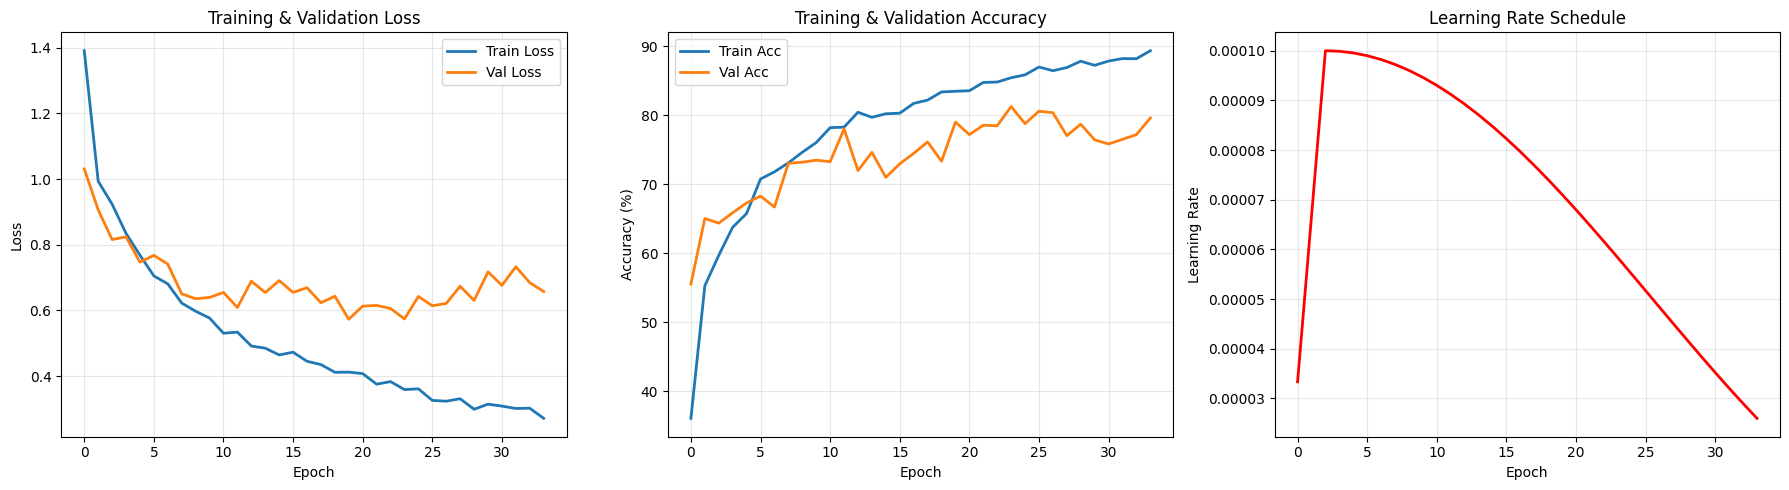

In [25]:
# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot([x*100 for x in history['train_acc']], label='Train Acc', linewidth=2)
axes[1].plot([x*100 for x in history['val_acc']], label='Val Acc', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training & Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Learning rate
axes[2].plot(history['lr'], linewidth=2, color='red')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Learning Rate')
axes[2].set_title('Learning Rate Schedule')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

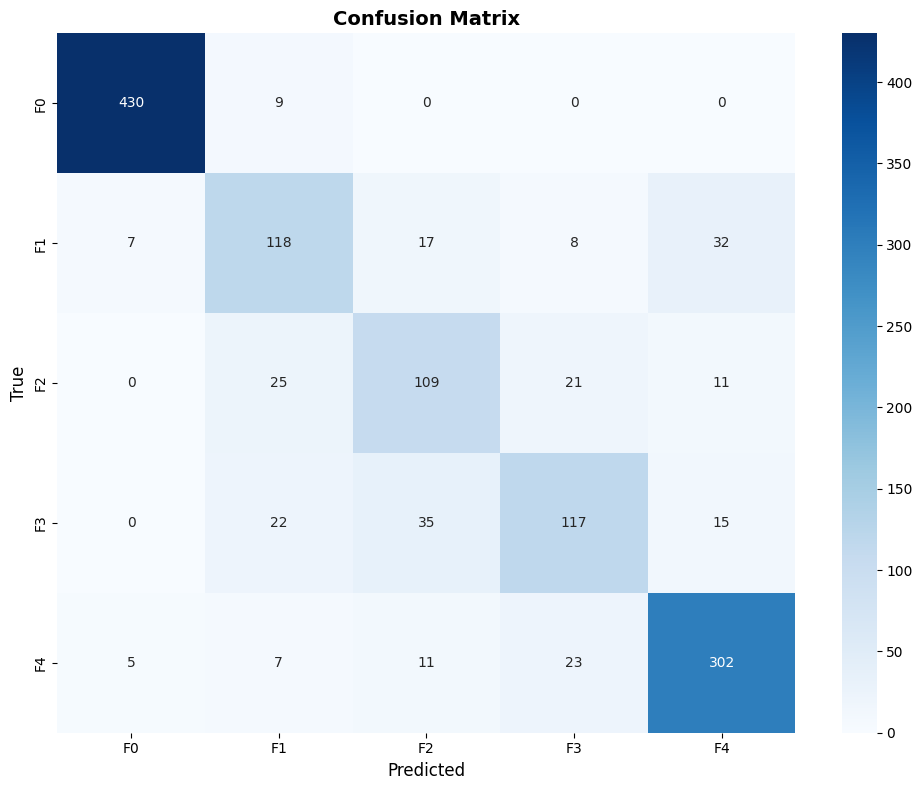


Classification Report:
              precision    recall  f1-score   support

          F0       0.97      0.98      0.98       439
          F1       0.65      0.65      0.65       182
          F2       0.63      0.66      0.64       166
          F3       0.69      0.62      0.65       189
          F4       0.84      0.87      0.85       348

    accuracy                           0.81      1324
   macro avg       0.76      0.75      0.76      1324
weighted avg       0.81      0.81      0.81      1324



In [26]:
# Confusion matrix
cm = confusion_matrix(val_targets, val_preds, labels=list(range(num_classes)))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(val_targets, val_preds, target_names=classes, zero_division=0))

## Step 8: Save Model

In [27]:
# Create output directory
output_dir = Path('outputs')
output_dir.mkdir(parents=True, exist_ok=True)

# Save model
torch.save(model.state_dict(), output_dir / 'alexnet_fixed_state_dict.pth')
torch.save(model, output_dir / 'alexnet_fixed_full_model.pt')

# Save metadata
metadata = {
    'version': 'fixed_v2.0',
    'model': 'alexnet',
    'config': CONFIG,
    'classes': classes,
    'num_classes': num_classes,
    'best_val_acc': float(best_val_acc),
    'epochs_trained': len(history['train_loss']),
    'train_images': len(train_indices),
    'val_images': len(val_indices),
    'train_groups': len(train_groups),
    'val_groups': len(val_groups),
    'similar_groups_found': len(similar_groups),
    'history': history,
}

with open(output_dir / 'alexnet_training_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"\nModel saved to {output_dir}/")
print(f"  - State dict: alexnet_fixed_state_dict.pth")
print(f"  - Full model: alexnet_fixed_full_model.pt")
print(f"  - Metadata: alexnet_training_metadata.json")


Model saved to outputs/
  - State dict: alexnet_fixed_state_dict.pth
  - Full model: alexnet_fixed_full_model.pt
  - Metadata: alexnet_training_metadata.json


## Summary

### Fixes Applied (from ResNet50 learnings):

#### 1. Data Leakage Prevention ✅
- Perceptual hashing to detect duplicates
- Group-level splitting (all similar images in same split)
- Verified no overlap between train/val
- **Reused cache from ResNet training** (same data, same splits!)

#### 2. Overfitting Reduction ✅
- **Data augmentation**: Flips, rotations, color jitter, etc.
- **Built-in Dropout**: AlexNet has 0.5 dropout in classifier (stronger than ResNet's 0.3!)
- **Weight decay**: L2 regularization (1e-4)
- **Early stopping**: Patience=10 epochs

#### 3. Training Improvements ✅
- **AdamW optimizer**: Better than Adam for weight decay
- **Cosine annealing**: Smooth learning rate decay
- **Warmup**: 3 epochs gradual LR increase
- **Mixed precision**: Faster training, less memory
- **Gradient clipping**: Prevents exploding gradients